In [1]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch.optim import AdamW
import random
import wandb
import os
# Fighting memory issues
from torch.amp import autocast, GradScaler
import gc

torch.cuda.empty_cache()
gc.collect()

# Throughout this code you'll see remnants of me fighting GPU memory issues
# while trying to use Llama 3. Ultimately I figured I can communicate
# with a smaller model.
model_checkpoint = "EleutherAI/gpt-neo-125m"
# model_checkpoint = "meta-llama/Meta-Llama-3-8B"
# os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Add this at the top of your notebook
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


/home/ubuntu/ml-takehome/slingshot-venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [2]:
wandb.init(project="ubuntu-conversation-turn-prediction-small")

# Fighting memory issues
def print_gpu_memory():
    print(f"Allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"Cached: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

def save_model_weights(model, file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    torch.save(model.state_dict(), file_path)
    print(f"Model weights saved to {file_path}")

def load_model_weights(model, file_path):
    if os.path.exists(file_path):
        model.load_state_dict(torch.load(file_path))
        print(f"Model weights loaded from {file_path}")
    else:
        print(f"No weights file found at {file_path}")
    return model


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: phillkin (matchacafe). Use `wandb login --relogin` to force relogin


In [3]:
print("Loading tokenizer, baseline LM model, and baseline label model...")
# Load the tokenizer, and both the LM model (for curiosity) and the label model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)
# lm_model = AutoModelForCausalLM.from_pretrained(model_checkpoint)
label_model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=5,
).to(DEVICE)


# Add WandB logging
wandb.watch(label_model)

Loading tokenizer, baseline LM model, and baseline label model...


Some weights of GPTNeoForTokenClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125m and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[]

In [4]:
# Constants we'll use
SEQ_LENGTH = 512 # Was using 2048, but running out of memory on GPU
BATCH_SIZE = 8
NUM_CLASSES = 5 # 5-star sentiment, we may try binary sentiment later; Curious since our labels
# are two classes (positive, negative), if 5-star sentiment will give us a smoother range
# of changing sentiment for confusing reviews, or if it'll barbell to 0 and 4

print("Loading Rated Ubuntu Conversations Dataset..")
df = pd.read_csv("data/10k-dialogues-sample-labeled.csv")
print(df.head())

## Analysis of unique values in the 'rating' column
# print("\nUnique values and their counts in 'rating' column:")
# rating_value_counts = df['rating'].value_counts(dropna=False).sort_index()
# for rating, count in rating_value_counts.items():
#     print(f"Rating {rating}: {count} ({count/len(df)*100:.2f}%)")
## Drop all NaN values
df = df.dropna()

# df = df.head(1000) # 🚨 TRUNCATE THE DATAFRAME TO 1000 ROWS TO TEST


# Analysis of dialogue lengths
print("\nAnalyzing dialogue lengths:")
dialogue_lengths = df['text'].str.len()
print(f"Mean dialogue length: {dialogue_lengths.mean():.2f}")
print(f"Median dialogue length: {dialogue_lengths.median():.2f}")
print(f"Max dialogue length: {dialogue_lengths.max()}")
print(f"Min dialogue length: {dialogue_lengths.min()}")
print(f"Dialogues longer than SEQ_LENGTH ({SEQ_LENGTH}): {(dialogue_lengths > SEQ_LENGTH).sum()} ({(dialogue_lengths > SEQ_LENGTH).mean()*100:.2f}%)")

# New analysis: Total dialogues longer than SEQ_LENGTH
total_dialogues = df.groupby('dialogueID')['text'].apply(' '.join)
total_dialogue_lengths = total_dialogues.str.len()
print(f"\nTotal dialogues: {len(total_dialogues)}")
print(f"Mean total dialogue length: {total_dialogue_lengths.mean():.2f}")
print(f"Min total dialogue length: {total_dialogue_lengths.min()}")
print(f"Max total dialogue length: {total_dialogue_lengths.max()}")
print(f"Total dialogues longer than SEQ_LENGTH ({SEQ_LENGTH}): {(total_dialogue_lengths > SEQ_LENGTH).sum()} ({(total_dialogue_lengths > SEQ_LENGTH).sum() / len(total_dialogues) * 100:.2f}%)")

# Count of rating labels
print("\nCount of rating labels:")
rating_counts = df['rating'].value_counts().sort_index()
for rating, count in rating_counts.items():
    print(f"Rating {rating}: {count} ({count/len(df)*100:.2f}%)")

# Rating labels per dialogue
print("\nRating labels per dialogue:")
dialogues_per_rating = df.groupby('dialogueID')['rating'].nunique()
print(dialogues_per_rating.value_counts().sort_index())


# Function to split data into train and test sets
def train_test_split(data, test_size=0.1):
    data_size = len(data)
    test_size = int(data_size * test_size)
    indices = list(range(data_size))
    random.shuffle(indices)
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

# Split the data into train and test sets
random.seed(404)  # for reproducibility
train_df, test_df = train_test_split(df, test_size=0.1)
print(f"Train set size: {len(train_df)}, Test set size: {len(test_df)}")


print("Extracting rating labels...")
train_sentiment_labels = torch.tensor(train_df["rating"].values.astype(int), dtype=torch.long)
test_sentiment_labels = torch.tensor(test_df["rating"].values.astype(int), dtype=torch.long)
print("Done")

Loading Rated Ubuntu Conversations Dataset..
   folder  dialogueID                      date      from        to  \
0       7  100000.tsv  2007-03-01T07:55:00.000Z     dyrne  martalli   
1       7  100000.tsv  2007-03-01T07:56:00.000Z  martalli       NaN   
2       7  100000.tsv  2007-03-01T07:57:00.000Z  martalli       NaN   
3       7  100000.tsv  2007-03-01T07:57:00.000Z     dyrne  martalli   
4       7  100000.tsv  2007-03-01T07:58:00.000Z  martalli       NaN   

                                                text  rating  
0  could you just put a script in inittab with th...     4.0  
1  Well, actually, I was planning somehting like ...     4.0  
2                         What would it be for edgy?     4.0  
3  im not sure about new init.  i think edgy stil...     4.0  
4  Regarding sound cards, I found this one:http:/...     4.0  

Analyzing dialogue lengths:
Mean dialogue length: 54.30
Median dialogue length: 42.00
Max dialogue length: 462
Min dialogue length: 1
Dialogues longe

In [5]:
# Tokenize the reviews and attach that to the dataframe
tokenizer.pad_token = tokenizer.eos_token
def extract_tokens(turn):
    # Returns [input_ids, attention_mask] for every dialogue, each of shape [1, SEQ_LENGTH]
    tokenizer_out = tokenizer(turn, return_tensors="pt", truncation=True, max_length=SEQ_LENGTH, padding="max_length")
    input_ids, attention_mask = tokenizer_out.input_ids, tokenizer_out.attention_mask
    return input_ids, attention_mask
# Convert reviews to token tensors
print("Tokenizing dialogues...")
train_dialogue_tokens_arr = [extract_tokens(turn) for turn in train_df['text']]
test_dialogue_tokens_arr = [extract_tokens(turn) for turn in test_df['text']]
print(f"Train Samples: {len(train_dialogue_tokens_arr)}, Test Samples: {len(test_dialogue_tokens_arr)}")
print(f"Shape of first train item: {test_dialogue_tokens_arr[0][0].shape}")

Tokenizing dialogues...
Train Samples: 245898, Test Samples: 27321
Shape of first train item: torch.Size([1, 512])


In [7]:
# Get a baseline loss for the untrained label model
total_loss = 0
num_batches = 0
batch_losses = []

def plot_loss(losses, title="Loss over batches", xlabel="Batch", ylabel="Loss"):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(losses) + 1), losses, marker='o')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

def process_batches(train=False, is_train_set=True, epochs=1):
    total_loss = 0
    num_batches = 0
    batch_losses = []

    # Set the model to train or eval mode
    label_model.train(train)

    # Choose the appropriate dataset
    dialogue_tokens = train_dialogue_tokens_arr if is_train_set else test_dialogue_tokens_arr
    sentiment_labels = train_sentiment_labels if is_train_set else test_sentiment_labels

    # Create optimizer if in training mode
    optimizer = AdamW(label_model.parameters(), lr=1e-5) if train else None
    scaler = GradScaler() if train else None

    # Gradient accumulation
    accumulation_steps = 8

    epoch_losses = []
    for epoch in range(epochs):
        epoch_total_loss = 0
        epoch_num_batches = 0
        print(f"Epoch {epoch + 1}/{epochs}")
        for i in range(0, len(dialogue_tokens), BATCH_SIZE):
            batch = dialogue_tokens[i:i+BATCH_SIZE]
            y_true_batch = sentiment_labels[i:i+BATCH_SIZE]
            y_true_batch = y_true_batch.to(DEVICE)
            # y_true_batch is of shape (BATCH_SIZE)

            # Prepare input tokens and attention masks for the model
            input_ids = torch.cat([item[0] for item in batch], dim=0).to(DEVICE)
            attention_mask = torch.cat([item[1] for item in batch], dim=0).to(DEVICE)

            with autocast('cuda'):
                # Get the logits for the batch (BATCH_SIZE, SEQ_LENGTH, NUM_CLASSES)
                label_outs_batch = label_model(input_ids=input_ids, attention_mask=attention_mask)

                # Extract the logits for the last non-padding token of each sequence
                last_non_pad_idx = attention_mask.sum(dim=1) - 1 # thanks gpt
                batch_size, seq_len, num_classes = label_outs_batch.logits.shape
                last_token_logits = label_outs_batch.logits[torch.arange(batch_size), last_non_pad_idx]

                # Reshape logits to (batch_size * sequence_length, num_classes)
                logits = label_outs_batch.logits.view(-1, NUM_CLASSES)

                # Compute the loss for the batch
                loss_fn = torch.nn.CrossEntropyLoss()
                loss = loss_fn(last_token_logits, y_true_batch)
                loss /= accumulation_steps

            batch_loss = loss.item()

            if train:
                scaler.scale(loss).backward()
                if (i // BATCH_SIZE + 1) % accumulation_steps == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()

            # Update progress
            progress = (i + BATCH_SIZE) / len(dialogue_tokens) * 100
            print(f"\rProcessing: [{i+BATCH_SIZE:5d}/{len(dialogue_tokens):5d}] {progress:6.2f}% | Batch {num_batches + 1} loss: {batch_loss:.4f}", end="", flush=True)

            # Accumulate the loss
            total_loss += batch_loss
            epoch_total_loss += batch_loss
            num_batches += 1
            epoch_num_batches += 1
            batch_losses.append(batch_loss)

            if train and epoch_num_batches % 100 == 0:
                # Save the model weights
                save_model_weights(label_model, "model_weights/conversation_classifier_checkpoint.pth")

            # Log batch loss to wandb
            wandb.log({"batch_loss": batch_loss, "batch": num_batches})

            # Clear unnecessary tensors
            del input_ids, attention_mask, y_true_batch, label_outs_batch, logits, loss
            torch.cuda.empty_cache()
            gc.collect()

        # Print GPU memory usage at the end of each epoch
        print_gpu_memory()

        # Calculate and print the average loss for the epoch
        epoch_average_loss = epoch_total_loss / epoch_num_batches
        epoch_losses.append(epoch_average_loss)
        print(f"Epoch {epoch + 1} average loss: {epoch_average_loss:.4f}")

        # Log epoch metrics to wandb
        wandb.log({
            "epoch": epoch + 1,
            "epoch_average_loss": epoch_average_loss,
        })

        if train:
            # Log learning rate to wandb
            wandb.log({"learning_rate": optimizer.param_groups[0]['lr']})

    # Calculate and print the overall average loss
    overall_average_loss = total_loss / num_batches
    print(f"\nOverall average loss: {overall_average_loss:.4f}")

    plot_loss(batch_losses, title="Loss over batches", xlabel="Batch", ylabel="Loss")

In [ ]:
print_gpu_memory()
torch.cuda.empty_cache()
gc.collect()
print("Processing baseline test set (untrained):")
process_batches(train=False, is_train_set=False)

Initial GPU memory usage:
Allocated: 0.52 GB
Cached: 0.54 GB
Training:
Epoch 1/1
Processing: [  800/245898]   0.33% | Batch 100 loss: 0.2346Model weights saved to model_weights/conversation_classifier_checkpoint.pth
Processing: [ 1600/245898]   0.65% | Batch 200 loss: 0.2359Model weights saved to model_weights/conversation_classifier_checkpoint.pth
Processing: [ 2400/245898]   0.98% | Batch 300 loss: 0.2452Model weights saved to model_weights/conversation_classifier_checkpoint.pth
Processing: [ 3200/245898]   1.30% | Batch 400 loss: 0.1638Model weights saved to model_weights/conversation_classifier_checkpoint.pth
Processing: [ 4000/245898]   1.63% | Batch 500 loss: 0.2260Model weights saved to model_weights/conversation_classifier_checkpoint.pth
Processing: [ 4800/245898]   1.95% | Batch 600 loss: 0.1709Model weights saved to model_weights/conversation_classifier_checkpoint.pth
Processing: [ 5600/245898]   2.28% | Batch 700 loss: 0.1808Model weights saved to model_weights/conversation_

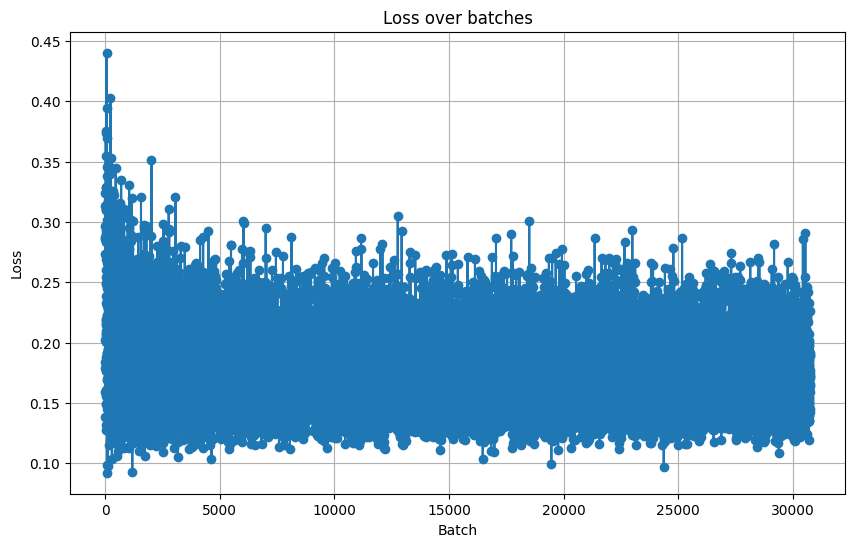

Final GPU memory usage:
Allocated: 1.06 GB
Cached: 2.23 GB
Processing test set (post-training):
Epoch 1/1
Processing: [27328/27321] 100.03% | Batch 3416 loss: 0.1065Allocated: 1.83 GB
Cached: 3.54 GB
Epoch 1 average loss: 0.1728

Overall average loss: 0.1728


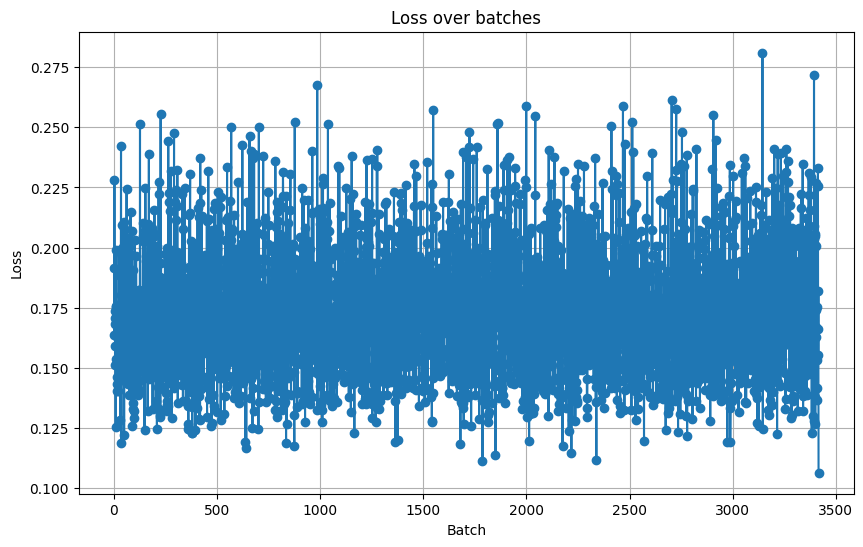

In [8]:
# Before running your training loop:
print("Initial GPU memory usage:")
print_gpu_memory()

########
# Big Training Run
########
print("Training:")
process_batches(train=True, is_train_set=True, epochs=1)

# After training:
print("Final GPU memory usage:")
print_gpu_memory()
torch.cuda.empty_cache()
gc.collect()

print("Processing test set (post-training):")
process_batches(train=False, is_train_set=False)

In [9]:
# Map the predicted classes to sentiment labels
sentiment_map = {0: "Very Negative", 1: "Negative", 2: "Neutral", 3: "Positive", 4: "Very Positive"}

def predict_sentiment(text, model=label_model):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=SEQ_LENGTH, padding="max_length")
    inputs = inputs.to(DEVICE)

    # Set the model to evaluation mode
    model.eval()

    # Disable gradient calculations
    with torch.no_grad():
        # Get the model outputs
        outputs = model(**inputs)
        logits = outputs.logits

    # Convert logits to probabilities
    probabilities = torch.nn.functional.softmax(logits, dim=-1)

    # Get the predicted classes for each token
    predicted_classes = torch.argmax(logits, dim=-1)

    # Get the overall sentiment (mode of all token predictions)
    overall_sentiment_class = torch.mode(predicted_classes[0]).values.item()
    overall_sentiment = sentiment_map[overall_sentiment_class]

    # Calculate overall confidence (mean of highest probabilities for each token)
    overall_confidence = torch.mean(torch.max(probabilities[0], dim=1).values).item()

    # Decode tokens and pair with their predicted classes
    tokens = tokenizer.convert_ids_to_tokens(inputs.input_ids[0])
    # Found this 'Ġ' character is space token, so removing it
    token_sentiments = [(token.replace('Ġ', ''), predicted_classes[0, i].item()) 
                        for i, token in enumerate(tokens) 
                        if token not in [tokenizer.pad_token, '<|endoftext|>']]

    return {
        "overall_sentiment": overall_sentiment,
        "overall_confidence": overall_confidence,
        "token_sentiments": token_sentiments
    }

# Get 3 random dialogueIDs
random_dialogues = df.groupby('dialogueID').first().sample(n=3)

# Extract the full conversations for these dialogueIDs
full_conversations = []
for dialogue_id in random_dialogues.index:
    conversation = df[df['dialogueID'] == dialogue_id].sort_values('date')['text'].tolist()
    full_conversations.append("\n".join(conversation))

# Concatenate the three dialogues
combined_dialogue = "\n-------\n".join(full_conversations)

# Print the combined dialogue
print("Combined Dialogue:")
print(combined_dialogue)
print("\n" + "="*50 + "\n")

# Predict sentiment on the combined dialogue
result = predict_sentiment(combined_dialogue, model=label_model)

# Print the results
print(f"Overall sentiment: {result['overall_sentiment']}")
print(f"Overall confidence: {result['overall_confidence']:.4f}")

# Print token-wise sentiment (limiting to first 50 tokens for brevity)
print("\nToken-wise sentiment (first 50 tokens):")
print(" ".join([f"{token}({sentiment})" for token, sentiment in result['token_sentiments']]))

Combined Dialogue:
please don't paste - it ain;t too bad more than 2 lines is paste
 you will need to restore the grub loader, after installing the other os's. Windows also wants to be on the 'first' partition of the drive in most cases.
 err.. so far from what ive seen DirectX 10 has been a total letdown
-------
what are you after?
so ndiswrapper?
some drivers won't work at all
ok but another question why when I run the command:  sudo dpkg -i filename.deb is asking me 4 password?
 do u think that package should work??
ndiswrapper doesnt work in all cases
or requires tweaking
i dont have any direct experience with ndiswrapper
your isp may be banned from -es
from a terminal   ./filename
 I have the code so is just copy the code into a file the exec the file?
make sure you only have official repos enabled, and follow !upgrade. and hope.
should I disable backports?
probably a good idea. anyway it's more a matter of what you have *installed* than what you have enabled, i'm afraid
you can a

In [10]:


# Example usage:
# Save the model weights
save_model_weights(label_model, "model_weights/conversation_classifier.pth")

# To load the weights later:
loaded_label_model = load_model_weights(label_model, "model_weights/conversation_classifier.pth")

predict_sentiment("This movie was absolutely fantastic! Great! I loved every minute of it. Except it fucking SUUUUCKED. Bad!", model=loaded_label_model)

Model weights saved to model_weights/conversation_classifier.pth


/tmp/ipykernel_17572/143478190.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(file_path))


Model weights loaded from model_weights/conversation_classifier.pth


{'overall_sentiment': 'Negative',
 'overall_confidence': 0.6162473559379578,
 'token_sentiments': [('This', 1),
  ('movie', 1),
  ('was', 1),
  ('absolutely', 1),
  ('fantastic', 1),
  ('!', 1),
  ('Great', 1),
  ('!', 1),
  ('I', 2),
  ('loved', 1),
  ('every', 0),
  ('minute', 1),
  ('of', 1),
  ('it', 1),
  ('.', 1),
  ('Except', 1),
  ('it', 1),
  ('fucking', 1),
  ('SU', 0),
  ('UU', 0),
  ('UCK', 0),
  ('ED', 1),
  ('.', 1),
  ('Bad', 1),
  ('!', 1)]}